# Matching float profiles to satellite pixels
## Import Packages

In [1]:
import pandas as pd
import xarray as xr
import glob
from pyhdf.SD import SD,SDC
import numpy as np
from datetime import *
from FromBieito.soccom_functions import *
from FromBieito.Calc_Chl import *
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

## Load in satellite data

In [3]:
rootdir = '../data/interim/'
files = sorted(glob.glob(rootdir+"/*.nc"))
print(files)

fd=xr.open_dataset(files[0])
display(fd)

['../data/interim\\npp_2014onwards.nc']


<xarray.Dataset>
Dimensions:  (lon: 1380, lat: 1080, date: 334)
Coordinates:
  * lon      (lon) float64 -74.96 -74.88 -74.79 -74.71 ... 39.79 39.87 39.96
  * lat      (lat) float64 -0.04167 -0.125 -0.2083 ... -89.79 -89.87 -89.96
  * date     (date) float64 7.356e+05 7.356e+05 ... 7.383e+05 7.383e+05
Data variables:
    npp      (date, lon, lat) float64 ...

### Time is in matlab datenum 
= Need to convert to datetime

* Pos ask about how to put the values into the xarray dataset, but for now, is made as a separate variable (means a few extra lines later on)

In [4]:
def datenum_to_datetime(datenum):
    """
    Convert Matlab datenum into Python datetime.
    :param datenum: Date in datenum format
    :return:        Datetime object corresponding to datenum.
    """
    days = datenum % 1
    return datetime.datetime.fromordinal(int(datenum)) \
           + timedelta(days=days) \
           - timedelta(days=366)

In [5]:
nz= len(fd.date.values)
datezz=[]
for i in range(0,nz):
    datezz=np.append(datezz,datenum_to_datetime(fd.date.values[i]))
print(datezz[0])

2014-01-04 23:59:59.500003


In [75]:
#display(fd['npp'].isel(date=6,lat=500,lon=800))
fd['npp'].isel(date=6,lat=500,lon=800).values

array(497.19674683)

## Load in float data
One at a time for the moment

In [83]:
file_folder = "../data/raw/WGfloats/" # specify directory relative to location of notebook #SOCCOM_HiResQC_LIAR_21Dec2021_netcdf
                # WGfloats
float_number = "5904471" #7900918 #9094/5904471 #5904397

files = sorted(glob.glob(file_folder+"/*"+float_number+"*.nc"))
#print(files)
#files = sorted(glob.glob(file_folder+"/*.nc"))

#uses the function that reads and grids the data
FLOAT = grids_one_buoy(files[0],display_info = False, DO_ml_crit = 2.5, clear_short = True)

#the gridded data is located in the dictionary FLOAT.gr, and contains the following variables
#print(FLOAT.gr.keys())
#print(FLOAT.raw_bg.keys())

print("This float is WMO code: %s"%(FLOAT.gr["WMO_code"]))

This float is WMO code: 5904471


## Match-up

### Get info from a single profile

In [61]:
print(FLOAT.gr["date_dt"][0])
print(FLOAT.gr["Lat"][0])
print(FLOAT.gr["Lon"][0])


2015-01-22 05:14:00.000004
-61.022
-0.028999999999996362


### Select satellite pixel and get NPP value

In [62]:
float_date = FLOAT.gr["date_dt"][0]
# get all differences with date as values 
cloz_dict = { 
  abs(float_date.timestamp() - date.timestamp()) : date 
  for date in datezz}
# extracting minimum key using min()
sat_date = cloz_dict[min(cloz_dict.keys())]
# printing result
print("Nearest date from float date : " + str(sat_date))

date_ix=np.where(datezz==sat_date)
date_sel=fd['date'][date_ix]

fd['npp'].sel(date=date_sel,lat=FLOAT.gr["Lat"][0],lon=FLOAT.gr["Lon"][0],method='nearest').values

Nearest date from float date : 2015-01-20 23:59:59.500003


array([831.43713379])

### Get info from profiles - all

In [63]:
import warnings
warnings.filterwarnings('ignore')
# because next cell has warnings for each iteration -- ask someone about them in future

In [119]:
fz=len(FLOAT.gr["date_dt"])
## Select satellite pixel and get NPP value
NPP_atprofiles=np.full(fz,np.nan)
sat_date=[]
for fix in range(0,fz):
    #print(FLOAT.gr["date_dt"][fix])
    #print(FLOAT.gr["Lat"][0])
    #print(FLOAT.gr["Lon"][0])
    float_date = FLOAT.gr["date_dt"][fix]
    # get all differences with date as values 
    cloz_dict = { 
      abs(float_date.timestamp() - date.timestamp()) : date 
      for date in datezz}
    # extracting minimum key using min()
    sat_date = np.append(sat_date,cloz_dict[min(cloz_dict.keys())])
    #print("Nearest date from float date : " + str(sat_date))
    #date_ix=[]
    date_ix=np.where(datezz==sat_date[fix])
    date_sel=fd['date'][date_ix]
    
    #NPP_atprofiles[fix]=fd['npp'].sel(date=date_sel,lat=FLOAT.gr["Lat"][0],lon=FLOAT.gr["Lon"][0],method='nearest').values
    NPP_atprofiles[fix]=fd['npp'].sel(date=date_sel,lat=FLOAT.gr["Lat"][fix],lon=FLOAT.gr["Lon"][fix],method='nearest').values
    #NPP_atprofiles[fix]=fd['npp'].sel(date=date_sel,lat=-50,lon=25,method='nearest').values # just choosing a randon single location to check code

In [120]:
NPP_atprofiles[np.where(NPP_atprofiles<0)]=np.nan
display(NPP_atprofiles)

array([         nan,          nan,          nan,          nan,
       690.24206543, 540.31512451, 371.45809937, 374.76550293,
       313.2336731 , 178.59417725,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan, 982.40441895, 777.51879883,
       848.88690186, 629.41229248, 346.51107788, 245.07223511,
       217.56832886,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,       

Text(0.5, 0, 'Date')

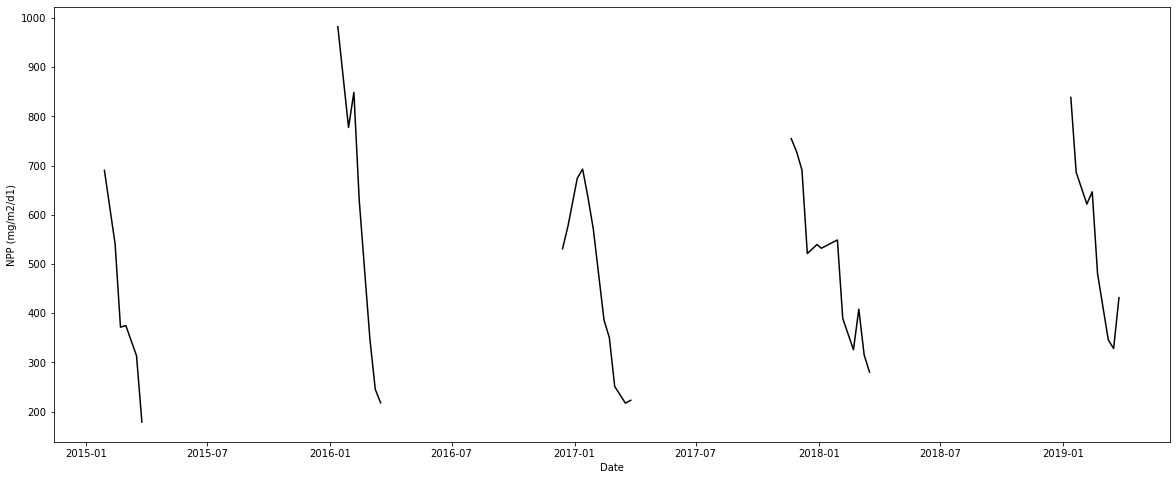

In [121]:
#Plot
fig = plt.subplots(figsize = (20, 8))
plt.plot(sat_date,NPP_atprofiles, c='black')
plt.ylabel('NPP (mg/m2/d1)')
plt.xlabel('Date')

### Functions

In [50]:
from PyAstronomy import pyasl

In [171]:
# calculate the vertically integrated data column inventory using the composite trapezoidal rule
def integrate(zi, data, depth_range):
    n_profs = len(data)
    zi_start = abs(zi - depth_range[0]).argmin() # find location of start depth
    zi_end =  abs(zi - depth_range[1]).argmin() # find location of end depth
    zi_struct = np.ones((n_profs, 1)) * zi[zi_start : zi_end] # add +1 to get the 200m value
    data = data[:, zi_start : zi_end] # add +1 to get the 200m value
    col_inv = []
    for n in range(0, len(data)):
        col_inv.append(np.trapz(data[n,:][~np.isnan(data[n,:])], zi_struct[n,:][~np.isnan(data[n,:])]))
    return col_inv

In [172]:
# calculate the vertically integrated data column inventory using the composite trapezoidal rule
def integrate_wMLD(zi, data, start_depth, MLD):
    #n_profs = len(data)
    zi_start = abs(zi - start_depth).argmin() # find index of start depth
    zi_end =  abs(zi - MLD).argmin() # find index of end depth
    zi_struct = zi[zi_start : zi_end] # add +1 to get the 200m value
    data = data[zi_start : zi_end] # add +1 to get the 200m value
    col_inv = []
    #for n in range(0, len(data)):
    col_inv.append(np.trapz(data[:][~np.isnan(data[:])], zi_struct[:][~np.isnan(data[:])]))
    return col_inv

In [173]:
def integrate_chl(data):
    # Interpolate/get data set up
    zi = np.arange(0, 2005, 5) # 5 = 400 depth intervals between 0m to 2000m
    #or zi=self.gr["depth"] #which = np.arange(0,2000+dz,dz)
    chl_int = FLOAT.gr["Chl_a"] # interpolated chl values across zi depth intervals for all profiles
    
    ### Using a fixed lower limit
    # Integrate chl - total chl in upper 200m
    upperlim=0
    lowerlim=200
    AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200'] = np.array(integrate(zi, chl_int.T, [upperlim, lowerlim])) # integrate interpolated nitrate values between 0m-200m 
    
    ### Using the deepest MLD seen by the float
    # Integrate chl - total chl in upper ML - to deepest MLD seen by float
    upperlim=0
    lowerlim=np.nanmax(FLOAT.gr["mld"])
    print(FLOAT.gr["WMO_code"],"Deepest mixed layer: %1.0f m"%(lowerlim))
    AllFloats[FLOAT.gr["WMO_code"]]['chl_intr_dMLD'] = np.array(integrate(zi, chl_int.T, [upperlim, lowerlim])) # integrate interpolated nitrate values between 0m-200m 

    ### Using the profile specific MLD
    H2=FLOAT.gr["mld"]
    nz= len(H2)
    # using MLD calculated for each individual profile
    chl_T=chl_int.T # the interpolated chl from FLOAT.gr
    AllFloats[FLOAT.gr["WMO_code"]]['dint_chla'] = np.full( nz, np.nan )
    for i in range(nz): #nz = length H2 (mld array) = number of profiles
        if np.isnan(H2[i]):
            AllFloats[FLOAT.gr["WMO_code"]]['dint_chla'][i] = np.nan # in float used to write code, there were some nan for MLD because of no salinity values recorded
        else:
            lowerlim=H2[i]
            data=chl_T[i,:]
            AllFloats[FLOAT.gr["WMO_code"]]['dint_chla'][i] = np.array(integrate_wMLD(zi, data, upperlim, lowerlim)) # integrate interpolated nitrate values between 0m-specificMLD
    
    ### The entire water column
    upperlim=0
    lowerlim=2000
    AllFloats[FLOAT.gr["WMO_code"]]['chl_intrWC'] = np.array(integrate(zi, chl_int.T, [upperlim, lowerlim])) # integrate interpolated nitrate values between 0m-200m 
    
    return AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200'],AllFloats[FLOAT.gr["WMO_code"]]['chl_intr_dMLD'],AllFloats[FLOAT.gr["WMO_code"]]['dint_chla'],AllFloats[FLOAT.gr["WMO_code"]]['chl_intrWC']
    #or return AllFloats                                      

In [287]:
def chl_underornoice(data,yix):
    H2=FLOAT.gr["mld"]
    nz= len(H2)
    ## How much of the annual chl was present under ice?
    AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno']=np.full(nz, np.nan)
    for i in range(nz):
        test=np.isnan(FLOAT.gr["Temperature"][0,i]) & np.isnan(FLOAT.gr["Temperature"][1,i]) & np.isnan(FLOAT.gr["Temperature"][2,i]) #& np.isnan(FLOAT.gr["Chl_a"][3,i]) #& np.isnan(FLOAT.gr["Chl_a"][4,i]) #& np.isnan(FLOAT.gr["Chl_a"][5,i])
        temp_thres=np.nanmedian(FLOAT.gr["Temperature"][0:4,i])<(-1.78)
        if test.all() | temp_thres.all():
            AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno'][i]=1
        else:
            AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno'][i]=0
    #### Over the whole float timeseries
    ui=np.where(np.isnan(FLOAT.gr["Chl_a"][0,:]) & np.isnan(FLOAT.gr["Chl_a"][1,:]) & np.isnan(FLOAT.gr["Chl_a"][2,:]) & np.isnan(FLOAT.gr["Chl_a"][3,:])) #& np.isnan(FLOAT.gr["Chl_a"][4,i]) #& np.isnan(FLOAT.gr["Chl_a"][5,i])
    ui_tot=np.nansum(AllFloats[FLOAT.gr["WMO_code"]]['chl_intr_dMLD'][ui])
    nui=np.where(np.isfinite(FLOAT.gr["Chl_a"][0,:]) & np.isnan(FLOAT.gr["Chl_a"][1,:]) & np.isnan(FLOAT.gr["Chl_a"][2,:]) & np.isnan(FLOAT.gr["Chl_a"][3,:])) #& np.isnan(FLOAT.gr["Chl_a"][4,i]) #& np.isnan(FLOAT.gr["Chl_a"][5,i])
    nui_tot=np.nansum(AllFloats[FLOAT.gr["WMO_code"]]['chl_intr_dMLD'][test])
    #print(np.nansum(chl_intr_dMLD))
    #print('approx % of chl under ice during float timeseries:', round(ui_tot/nui_tot*100,2),'%')
    
    #### get index for profiles that are in austral year, under ice and ice free
    AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"]=[]
    AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"]=[]
    AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"]=[]
    for i in range(len(FLOAT.gr["date_dt"])):
        decy = pyasl.decimalYear(FLOAT.gr["date_dt"][i]) #might be more efficient to make decy an np.int_ here so all the logical queries can be called at once?...
        smol=decy>=(yix-0.5)
        tol=decy<(yix+0.5)
        underice=AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno'][i]>0
        icefree=AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno'][i]==0
        if smol==tol:
            AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"]=np.append(AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"],np.int_(i))
        if smol==tol==underice:
            AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"]=np.append(AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"],i)
        if smol==tol==icefree:
            AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"]=np.append(AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"],i)
    AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"]=np.int_(AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"])
    AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"]=np.int_(AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"])
    AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"]=np.int_(AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"])
    # pos exlude years with <34 profiles from next lot of calculations?
    ### Calculate how much Chl is present at specific times - whole year, under ice, when there's no ice
    #could add if rule: if len(AllFloats['5904472'][endyear]["aust_ix"])<34: continue... or [] =np.nan
    #### Total in austral year
    AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_aus_chl"]=np.round(np.nansum(AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200'][AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"]]),6)
    #### Total under ice
    AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_underice_chl"]=np.round(np.nansum(AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200'][AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"]]),6)
    #### Total when ice-free
    AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_icefree_chl"]=np.round(np.nansum(AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200'][AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"]]),6)
    #### proportion under ice for austral year
    AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_underice"]=AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_underice_chl"]/AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_aus_chl"]
    AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_icefree"]=AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_icefree_chl"]/AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_aus_chl"]
    #### Mean [Chl] in WC
    #AllFloats['5904472'][yix]["Mean_aus_chl"]=np.round(np.nanmean(chl_intrWC[AllFloats['5904472'][yix]["aust_ix"]]),6)
    #for yix in range(startyear,endyear+1,1):
    print(yix,"under ice",np.round(AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_underice"],3))
    #for yix in range(startyear,endyear+1,1):
    #    print(yix,"ice free",np.round(AllFloats['5904472'][yix]["Prop_icefree"],3))
    
    #return AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno'],AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"],AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"],AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"],AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_aus_chl"],AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_underice_chl"],AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_icefree_chl"],AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_underice"],AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_icefree"]
    return AllFloats

In [296]:
def nosat_chl(data,yix):
    ## What is happening to the chl when the satellite isn't seeing the ice-free waters (from ~mid March)?
    Mar3015=datetime.datetime(2015,3,30)
    decmar15=pyasl.decimalYear(Mar3015)
    Mar2116=datetime.datetime(2016,3,21)
    decmar16=pyasl.decimalYear(Mar2116)
    Mar2217=datetime.datetime(2017,3,22)
    decmar17=pyasl.decimalYear(Mar2217)
    Mar1418=datetime.datetime(2018,3,14)
    decmar18=pyasl.decimalYear(Mar1418)
    Mar1419=datetime.datetime(2019,3,14)
    decmar19=pyasl.decimalYear(Mar1419)
    Mar2120=datetime.datetime(2020,3,21)
    decmar20=pyasl.decimalYear(Mar2120)

    AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"]=[]
    for i in range(len(FLOAT.gr["date_dt"])):
        decy = pyasl.decimalYear(FLOAT.gr["date_dt"][i])
        smol=decy>=(yix-0.5)
        tol=decy<(yix+0.5)
        icefree=AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno'][i]==0
        if yix==2015:
            mar=decy>=decmar15
        elif yix==2016:
            mar=decy>decmar16
        elif yix==2017:
            mar=decy>decmar17
        elif yix==2018:
            mar=decy>decmar18
        elif yix==2019:
            mar=decy>decmar19
        elif yix==2020:
            mar=decy>decmar20
        elif yix==2021:
            continue
        if smol==tol==mar: #==icefree
            AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"]=np.append(AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"],i)
        AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"]=np.int_(AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"])
    
    #could add if rule: if len(AllFloats['5904472'][endyear]["aust_ix"])<34: continue... or [] =np.nan
    #### Total chl when satellite field of view reduces during March, but before ice returns
    AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_nosat_chl"]=np.round(np.nansum(AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200'][AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"]]),6)
    #### proportion under ice for austral year
    AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_nosat"]=AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_nosat_chl"]/AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_aus_chl"]
    print(yix,"no satellite coverage",np.round(AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_nosat"],3))
    return AllFloats

### Calculate depth integrated chl to compare to satellite NPP

In [305]:
#make structure for floats 
AllFloats = {}

for f_ix in range(0,len(files)):
    #FLOAT = grids_one_buoy(files[f_ix],display_info = False, DO_ml_crit = 2.5, clear_short = True)
    AllFloats[FLOAT.gr["WMO_code"]] = {}
    AllFloats[FLOAT.gr["WMO_code"]]['dates_dt']=FLOAT.gr["date_dt"]
    #upperlim=0
    #lowerlim=np.nanmax(FLOAT.gr["mld"])
    #print(FLOAT.gr["WMO_code"],"Deepest mixed layer: %1.0f m"%(lowerlim))
    AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200'],AllFloats[FLOAT.gr["WMO_code"]]['chl_intr_dMLD'],AllFloats[FLOAT.gr["WMO_code"]]['dint_chla'],AllFloats[FLOAT.gr["WMO_code"]]['chl_intrWC']=integrate_chl(FLOAT)
    
    ##### Get year range
    startyear=FLOAT.gr["date_dt"][0].year
    endyear=FLOAT.gr["date_dt"][-1].year
    #print(startyear, '-', endyear)
    
    nosat_temp=[] # getting 0/1 for no sat coverage at the end of the year for plotting later
    
    for yix in range(startyear,endyear+1,1):
        AllFloats[FLOAT.gr["WMO_code"]][yix] ={}
        AllFloats=chl_underornoice(FLOAT,yix)
        AllFloats=nosat_chl(FLOAT,yix)
        
        nosat_temp=(np.append(nosat_temp,AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"]))
    
    AllFloats[FLOAT.gr["WMO_code"]]['no_sat_yesno']=np.full(len(AllFloats[FLOAT.gr["WMO_code"]]['dates_dt']), np.nan) # getting 0/1 for no sat coverage at the end of the year for plotting later
    for i in range(0,len(AllFloats[FLOAT.gr["WMO_code"]]['dates_dt'])): # getting 0/1 for no sat coverage at the end of the year for plotting later
        if (len(list(filter (lambda x : x == i, nosat_temp))) > 0):
            #print(i)
            AllFloats[FLOAT.gr["WMO_code"]]['no_sat_yesno'][i]=1
        else:
            AllFloats[FLOAT.gr["WMO_code"]]['no_sat_yesno'][i]=0

#display(AllFloats)

#chl_plot=AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200']
chl=AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200']
date=AllFloats[FLOAT.gr["WMO_code"]]['dates_dt']

fig = plt.figure(figsize = (25,20))
ax0 = fig.add_axes([0.07,0.65,0.47,0.27])
ax0.plot(date,chl)
ax0.set_ylim(0)
ax0.set_ylabel('$\mathregular {Depth Integrated Chlorophyll (mg/m^2)}$')

ax1=ax0.twinx()
ax1.plot(sat_date,NPP_atprofiles, c='black',linewidth=3)
ax1.set_ylabel('$\mathregular {Daily NPP Rates (mgC/m^2/d^1)}$')

underice4,=ax0.plot(FLOAT.gr["date_dt"],(AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno']*(np.nanmax(chl))),c='lightblue',ls=':',lw=3)
#nosat__,=ax0.plot(FLOAT.gr["date_dt"],(AllFloats[FLOAT.gr["WMO_code"]]['no_sat_yesno']*(np.nanmax(chl))),c='orange',ls=':',lw=3)